## Project: Detection of Powder Mildew Diesase in Leaves using Convultion Nerual Network

## Objectives

* Fetch Data from Kaggle: Data is Fetch from Kaggle using Kaggle Api. The cherry leaves dataset was downloaded from Kaggle and extracted which is then used in this project to analyze healthy versus powdery mildew-infected cherry leaves.

* Preprocess and Augment Data: Different techniques of image processing and arugmentation were implemented to preprare the dataset for the training of the model. this include techniques like  rotating, shifting, shearing, zooming, and flipping the images to increase the diversity of the training set.

* Exploratory Data Analysis: Visulization of Dataset to understand the overall distrbution of class for each class, as well as analyze average color dirstribution and variablity among the class. These analysis helps overall in understand the dataset and difference between healthy and powder midlew leaves.

* Model Training and Evaluation: Creation of Convoluation neural network model to train on cherry leaf imgaes so that it can be classify into healthy and powdery mildew classes. The technique include setting like early stopping which prevent overffting and methods like confusion matrix and classfication report to evaluate the performance of model.

* Save Model: Method to save the model which then can be used for front end application.

## Inputs
* Cherry Leaves Dataset from Kaggle: This dataset contains images of cherry leaves, which is divied into two classed (powder mildew and healthy). The dataset can be dowmloaded from https://www.kaggle.com/datasets/codeinstitute/cherry-leaves)

* Libraries: TensorFlow, Keras, NumPy, Matplotlib, Seaborn and OpenCV are used for data manipulation, modeling, and visualization.

## Outputs
* Trained Model: Model saved filee (cherry_leaf_model.h5) that can be used in front end app to classify cherry leaves into healthy or powdery mildew.

* Data Visualizations: Differnt plots that shows overall class distribution, average color distribution, the difference between average images, and image montages of the leaves.

* Model Performance Metrics: Plots of training/validation loss and accuracy, confusion matrix, and a classification report to show oveall model performance

## Additional Comments
* To download the Data from Kaggle, You need to download you kaggle Api from your Account. Simply go to Your Kaggle Account Setting, then on API click create New token

## Load Data From Kaggle

In [1]:
! mkdir ~/.kaggle

In [2]:
! cp kaggle.json ~/.kaggle/

In [3]:
! chmod 600 ~/.kaggle/kaggle.json

## Download Data

In [4]:
! kaggle datasets download codeinstitute/cherry-leaves

 84% 46.0M/55.0M [00:01<00:00, 33.9MB/s]
100% 55.0M/55.0M [00:01<00:00, 45.5MB/s]


## Extract Dataset

In [5]:
import zipfile
with zipfile.ZipFile('/content/cherry-leaves.zip', 'r') as zip_ref:
    zip_ref.extractall('plant')

## Libraries

In [26]:
!pip install keras-tuner --upgrade

In [39]:
import os
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from keras_tuner import RandomSearch
from tensorflow.keras.regularizers import l2

## Load Data

In [7]:
dataset_dir = '/content/plant/cherry-leaves'
healthy_dir = os.path.join(dataset_dir, 'healthy')
mildew_dir = os.path.join(dataset_dir, 'powdery_mildew')

## Loading Images

In [8]:
healthy_images = [os.path.join(healthy_dir, file) for file in os.listdir(healthy_dir)]
mildew_images = [os.path.join(mildew_dir, file) for file in os.listdir(mildew_dir)]

## Data Visulization

* Image Montage

In [11]:
def display_images(image_paths, title='Images'):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        if i >= len(image_paths):
            break
        plt.subplot(3, 3, i + 1)
        img = cv2.imread(image_paths[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

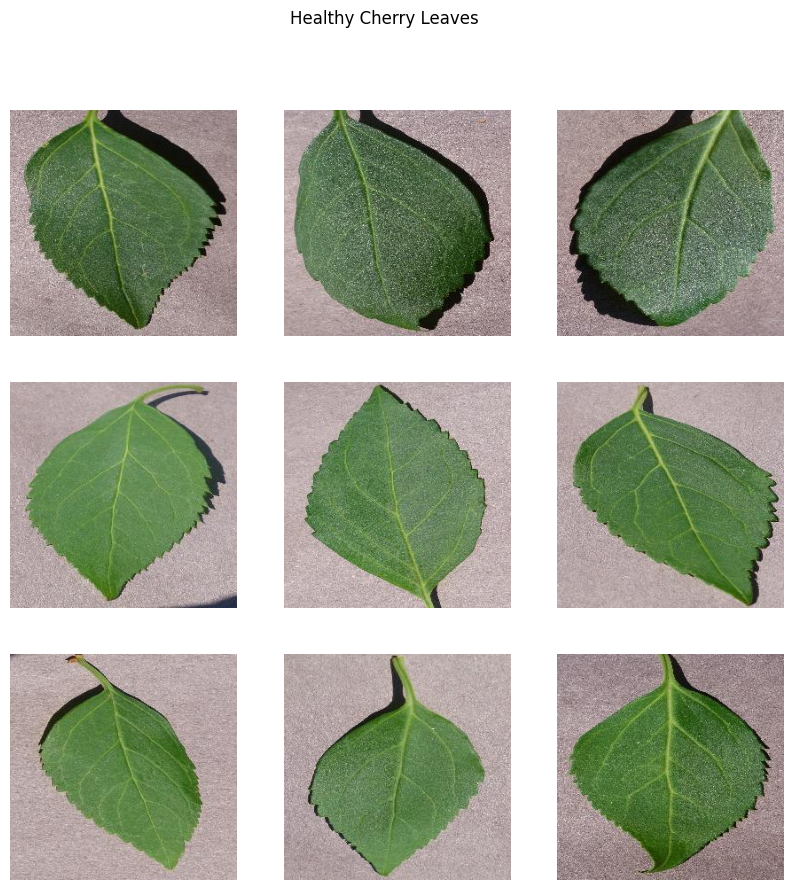

In [12]:
display_images(healthy_images, title='Healthy Cherry Leaves')

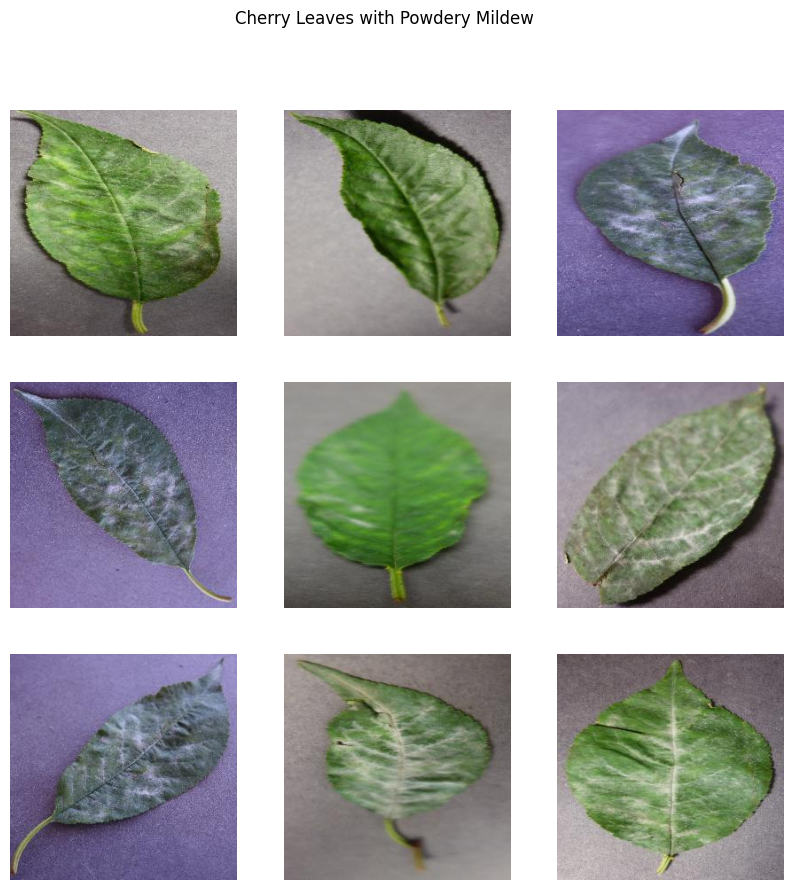

In [13]:
display_images(mildew_images, title='Cherry Leaves with Powdery Mildew')

## Checking Class Balance

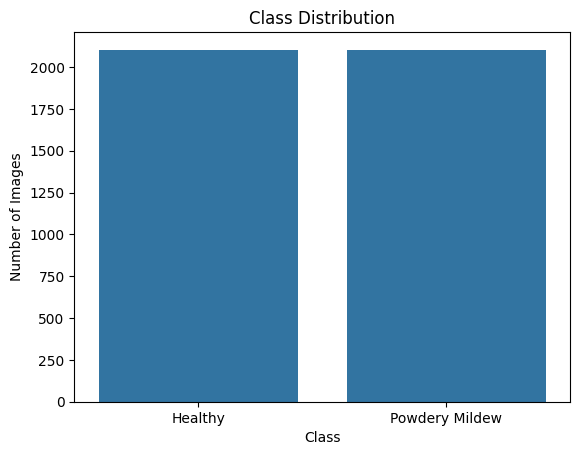

In [14]:
class_counts = [len(healthy_images), len(mildew_images)]
class_names = ['Healthy', 'Powdery Mildew']

sns.barplot(x=class_names, y=class_counts)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()

## Average Color Distribution

*  Average color channels of healthy and mildew leaves to compute variability


In [15]:
def compute_average_image_color(image_paths):
    average_colors = []
    std_dev_colors = []
    for path in image_paths:
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        average_colors.append(np.mean(img, axis=(0, 1)))
        std_dev_colors.append(np.std(img, axis=(0, 1)))
    return np.array(average_colors), np.array(std_dev_colors)

In [17]:
healthy_avg_color, healthy_std_dev_color = compute_average_image_color(healthy_images)
mildew_avg_color, mildew_std_dev_color = compute_average_image_color(mildew_images)

healthy_mean = np.mean(healthy_avg_color, axis=0)
mildew_mean = np.mean(mildew_avg_color, axis=0)
difference = np.abs(healthy_mean - mildew_mean)

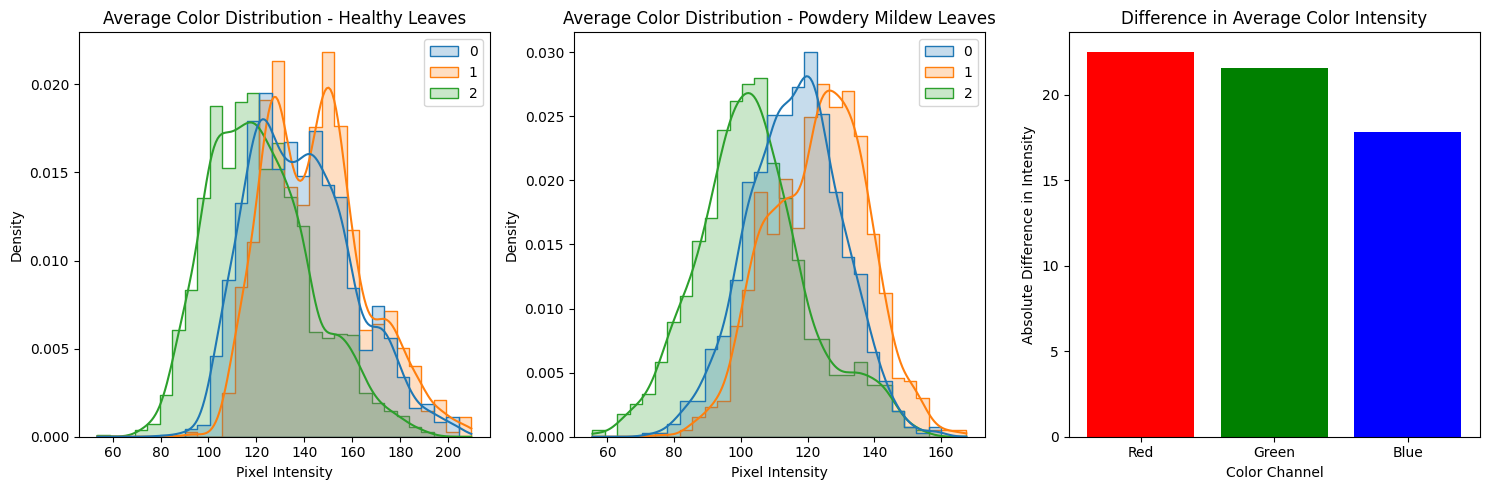

In [21]:
plt.figure(figsize=(15, 5))

# Histogram for healthy leaves
plt.subplot(1, 3, 1)
sns.histplot(healthy_avg_color, bins=30, kde=True, stat="density", element="step", common_norm=False)
plt.title('Average Color Distribution - Healthy Leaves')
plt.xlabel('Pixel Intensity')
plt.ylabel('Density')

# Histogram for powdery mildew leaves
plt.subplot(1, 3, 2)
sns.histplot(mildew_avg_color, bins=30, kde=True, stat="density", element="step", common_norm=False)
plt.title('Average Color Distribution - Powdery Mildew Leaves')
plt.xlabel('Pixel Intensity')
plt.ylabel('Density')

# Differences in average color intensity
plt.subplot(1, 3, 3)
colors = ['Red', 'Green', 'Blue']
plt.bar(colors, difference, color=['red', 'green', 'blue'])
plt.title('Difference in Average Color Intensity')
plt.xlabel('Color Channel')
plt.ylabel('Absolute Difference in Intensity')

plt.tight_layout()
plt.show()

## Model Training

In [22]:
## Image Size and Batch
img_width, img_height = 128, 128 ## Shape
batch_size = 32

## Creating Training Data

In [28]:
train_datagen = ImageDataGenerator(
    rescale=1./255,         # Normalize pixel values
    rotation_range=40,      # Random rotation between 0 and 40 degrees
    width_shift_range=0.2,  # Random horizontal shift
    height_shift_range=0.2, # Random vertical shift
    shear_range=0.2,        # Shear transformations
    zoom_range=0.2,         # Random zoom
    horizontal_flip=True,   # Random horizontal flip
    fill_mode='nearest',    # Strategy for filling newly created pixels
    validation_split=0.2    # Reserve 20% of images for validation
)

train_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
    seed=42
)

Found 3368 images belonging to 2 classes.


## Creating Validation Data

In [29]:
test_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    seed=42
)

Found 840 images belonging to 2 classes.


## Creating Test Data

In [30]:
def split_validation_set(generator, split_size=0.5):
    data_list = []
    labels_list = []
    batch_index = 0

    while batch_index <= generator.batch_index:
        data, labels = generator.next()
        data_list.append(data)
        labels_list.append(labels)
        batch_index = batch_index + 1

    data_array = np.vstack(data_list)
    labels_array = np.concatenate(labels_list)

    split_index = int(len(data_array) * split_size)

    validation_data = data_array[:split_index]
    validation_labels = labels_array[:split_index]
    test_data = data_array[split_index:]
    test_labels = labels_array[split_index:]

    return (validation_data, validation_labels), (test_data, test_labels)

In [31]:
(validation_data, validation_labels), (test_data, test_labels) = split_validation_set(validation_generator)

## Creating Model



In [32]:
def build_model(hp):
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(img_width, img_height, 3)))
    model.add(MaxPooling2D(2,2))

    for i in range(hp.Int('num_conv_layers', 1, 3)):
        model.add(Conv2D(filters=hp.Int('filters_' + str(i), 32, 128, step=32),
                         kernel_size=(3,3),
                         activation='relu'))
        model.add(MaxPooling2D(2,2))

    model.add(Flatten())
    model.add(Dense(units=hp.Int('units', min_value=32, max_value=128, step=32), activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=tf.keras.optimizers.Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

## Hyper Paramter Tunning

In [33]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='model_tuning',
    project_name='CherryLeaves'
)

In [34]:
tuner.search(train_generator,
             epochs=10,
             validation_data=validation_generator,
             callbacks=[EarlyStopping(monitor='val_loss', patience=3)])

Trial 10 Complete [00h 04m 29s]
val_accuracy: 0.9940476417541504

Best val_accuracy So Far: 0.9988095164299011
Total elapsed time: 00h 39m 04s


## Best Parameters

In [36]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Unites:", best_hps.get('units'))
print("Best Learning Rate:", best_hps.get('learning_rate'))

Best Unites: 32
Best Learning Rate: 0.00022386931737298818


## Final Model

In [40]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),

    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),

    Dense(1, activation='sigmoid')
])

## Model Summary

In [41]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 14, 14, 128)      

## Complie Model

In [42]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

## Early Stopping Method

In [43]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='min', restore_best_weights=True) ##Early stopping as a technique to prevent overfitting

## Training Model

In [44]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[early_stopping]
)

Epoch 1/10
105/105 [==============================] - 36s 320ms/step - loss: 0.6552 - accuracy: 0.6439 - val_loss: 0.3769 - val_accuracy: 0.8666
Epoch 2/10
105/105 [==============================] - 22s 211ms/step - loss: 0.2497 - accuracy: 0.9379 - val_loss: 0.2869 - val_accuracy: 0.9159
Epoch 3/10
105/105 [==============================] - 22s 212ms/step - loss: 0.2054 - accuracy: 0.9508 - val_loss: 0.1116 - val_accuracy: 0.9856
Epoch 4/10
105/105 [==============================] - 22s 212ms/step - loss: 0.1283 - accuracy: 0.9730 - val_loss: 0.0903 - val_accuracy: 0.9916
Epoch 5/10
105/105 [==============================] - 24s 227ms/step - loss: 0.1384 - accuracy: 0.9742 - val_loss: 0.1278 - val_accuracy: 0.9772
Epoch 6/10
105/105 [==============================] - 23s 221ms/step - loss: 0.1285 - accuracy: 0.9796 - val_loss: 0.0985 - val_accuracy: 0.9844
Epoch 6: early stopping


## Model Loss and Accuracy

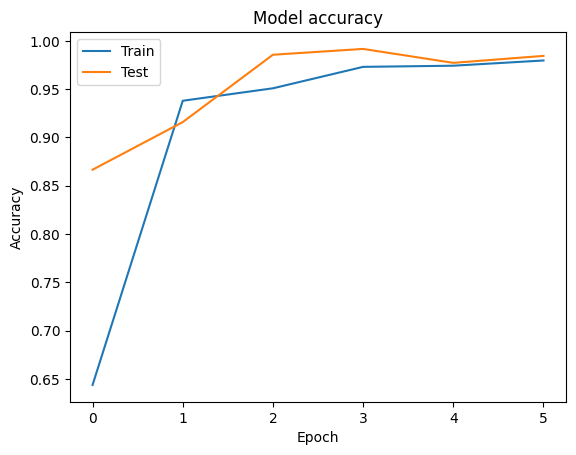

In [45]:
# training & validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

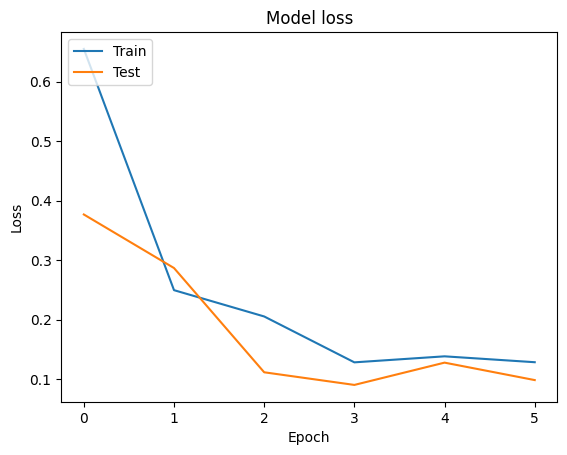

In [46]:
# training & validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Model Evaluation

In [47]:
test_loss, test_accuracy = model.evaluate(test_data, test_labels, verbose=1)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

14/14 [==============================] - 0s 22ms/step - loss: 0.1008 - accuracy: 0.9857
Test Accuracy: 0.9857
Test Loss: 0.1008


## Confusion Matrix

14/14 [==============================] - 0s 7ms/step


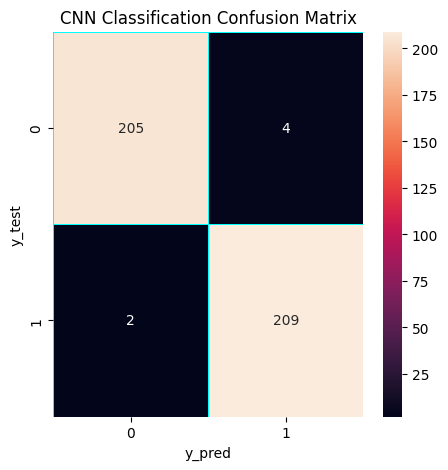

In [48]:
test_predictions = model.predict(test_data)
test_predictions = np.round(test_predictions).astype(int)

conf_matrix = confusion_matrix(test_labels, test_predictions)
plt.figure(figsize = (5, 5))
sns.heatmap(conf_matrix, annot=True, linewidth=0.7, linecolor='cyan', fmt='.0f')
plt.title('CNN Classification Confusion Matrix')
plt.xlabel('y_pred')
plt.ylabel('y_test')
plt.show()

In [49]:
print("\nClassification Report:")
class_report = classification_report(test_labels, test_predictions)
print(class_report)


Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99       209
         1.0       0.98      0.99      0.99       211

    accuracy                           0.99       420
   macro avg       0.99      0.99      0.99       420
weighted avg       0.99      0.99      0.99       420



## Save Model

In [50]:
model.save('cherry_leaf_model.h5')
print("Model saved successfully!")

Model saved successfully!


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
